# Imports

In [1]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=5efe3fdd615d02e54b4b1d51b8ca28d0ce90868d1e58c6df728e0b923dbc1e41
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
!pip install calmap

In [3]:

### importamos librerías

'''
instalar:
- plotly
- calmap
- folium
- wget
'''

#analisis
import pandas as pd 
import numpy as np

#visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import calmap
import folium

#paletas
confirmados='#393e46'
fallecidos='#ff2e63'

import wget
import os

# Data Loading

In [4]:

def read_FAO(fileName):
	import requests 
	file_url = "https://fenixservices.fao.org/faostat/static/bulkdownloads/"+fileName+".zip"
		
	r = requests.get(file_url, stream = True) 

	with open("temporalFile.zip", "wb") as file: 
		for block in r.iter_content(chunk_size = 1024): 
			if block: 
				file.write(block) 
		
	!unzip temporalFile.zip 

	Database = fileName + ".csv"	
	df = pd.read_csv(Database, encoding = "ISO-8859-1")

	return df




In [5]:

df_food_balances = read_FAO("FoodBalanceSheets_E_All_Data_(Normalized)")

df_emissions = read_FAO("Environment_Emissions_by_Sector_E_All_Data_(Normalized)")

df_food_transport = read_FAO("Environment_Transport_E_All_Data_(Normalized)")

df_waste_disposal = read_FAO("Emissions_Agriculture_Waste_Disposal_E_All_Data_(Normalized)")




Archive:  temporalFile.zip
  inflating: FoodBalanceSheets_E_All_Data_(Normalized).csv  
  inflating: FoodBalanceSheets_E_Flags.csv  
Archive:  temporalFile.zip
  inflating: Environment_Emissions_by_Sector_E_All_Data_(Normalized).csv  
  inflating: Environment_Emissions_by_Sector_E_Flags.csv  
Archive:  temporalFile.zip
  inflating: Environment_Transport_E_All_Data_(Normalized).csv  
 extracting: Environment_Transport_E_Flags.csv  
Archive:  temporalFile.zip
  inflating: Emissions_Agriculture_Waste_Disposal_E_All_Data_(Normalized).csv  
  inflating: Emissions_Agriculture_Waste_Disposal_E_Flags.csv  


In [16]:
def show_and_fill_na_values(df_input):
  # create a smaller df

  df_input["MeasuredItem"]= df_input["Item"] + "-"+ df_input["Element"]

  # in order to show and fill na we aggregate a little bit the info

  df_input["area_measure_item"] = df_input["Area"] + "-"+ df_input["MeasuredItem"] 

  short_df = df_input[["Year", "Value","area_measure_item"]]


  # show  gaps in the data

  gb_df_ = short_df.pivot_table(index = ["Year"], columns = ['area_measure_item'], values = "Value", aggfunc = sum).isnull()
  gb_df_= gb_df_.fillna(0)

  order_of_columns = list(gb_df_.sum().sort_values().index)
  
  gb_df_ = gb_df_[order_of_columns]


  plt.figure(figsize = (20, 10))
  plot = sns.heatmap(gb_df_, cbar = True, cmap = "inferno")
  plot.set_title("Null values in dataset");

  
  return df_input







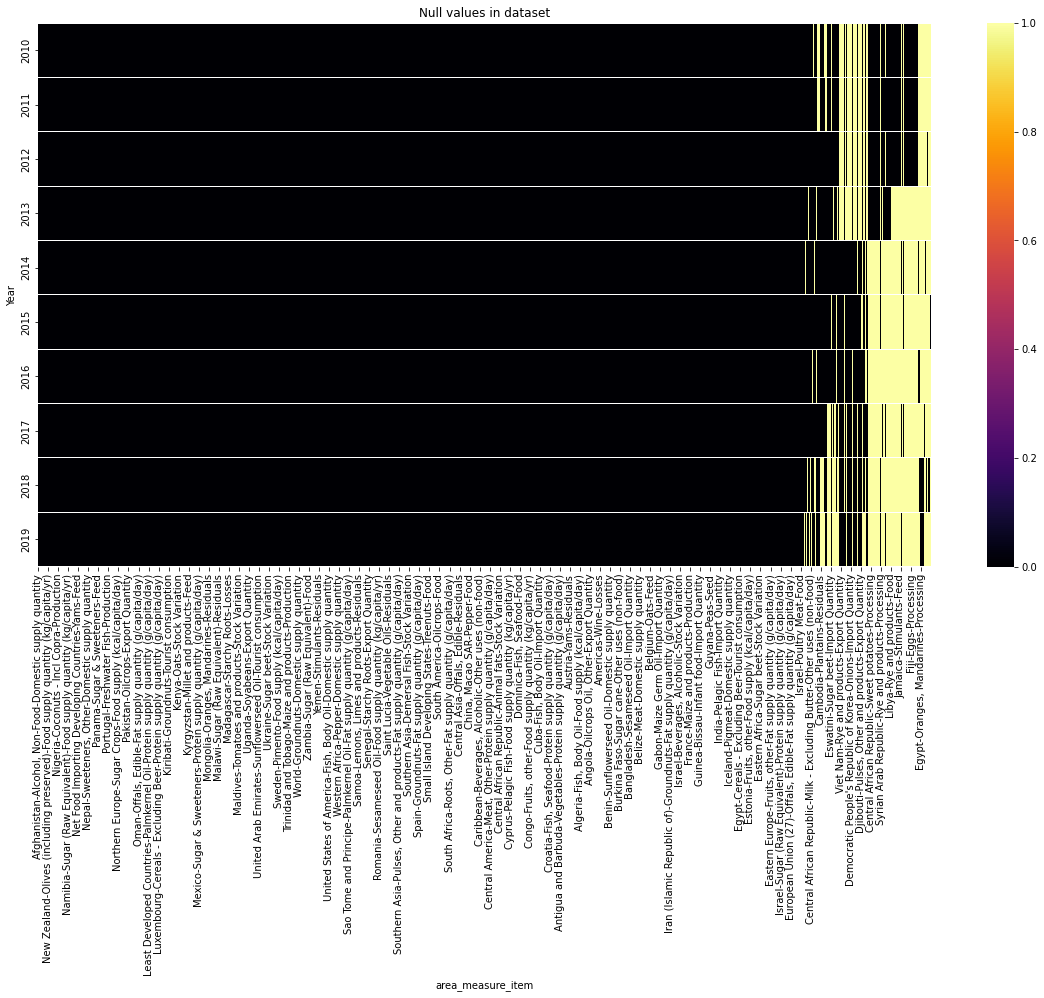

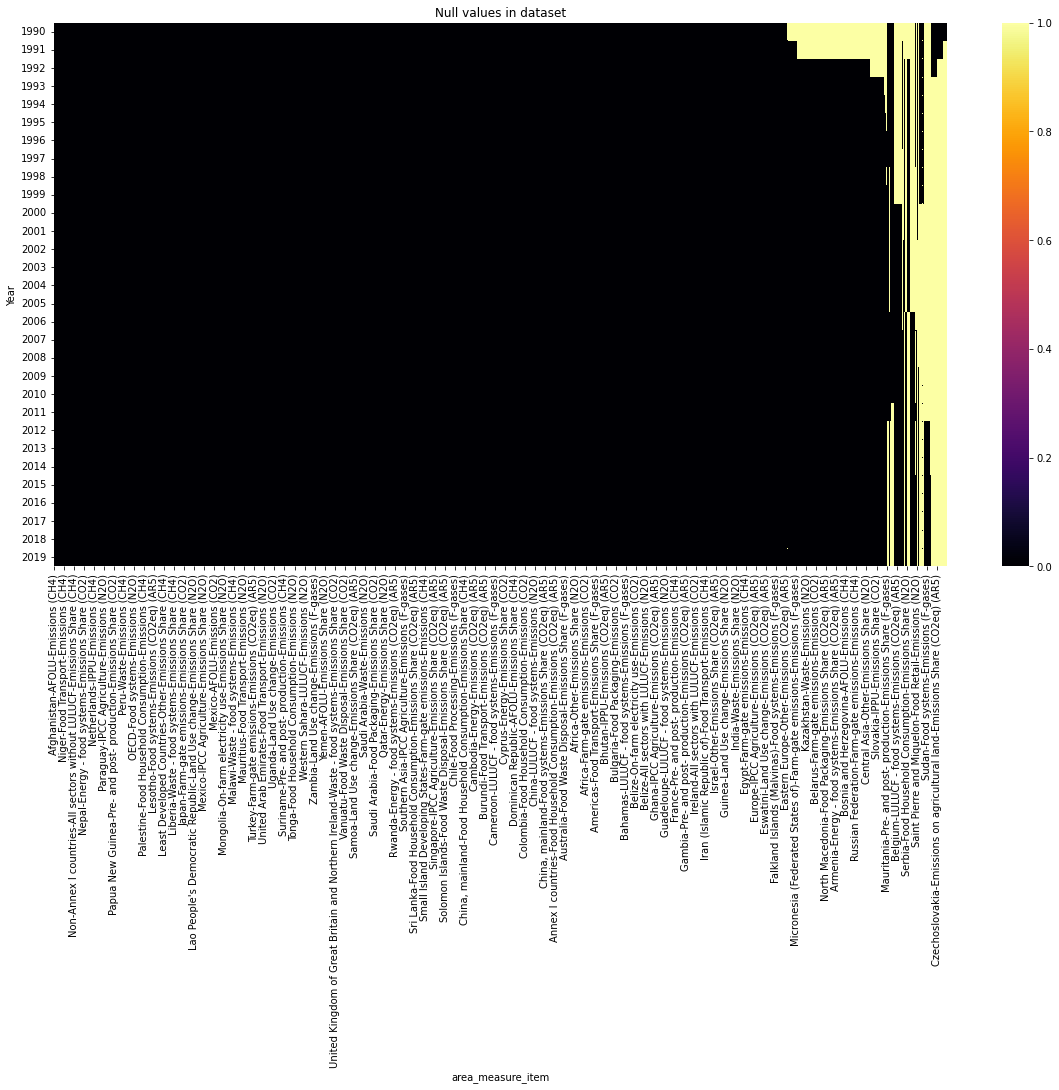

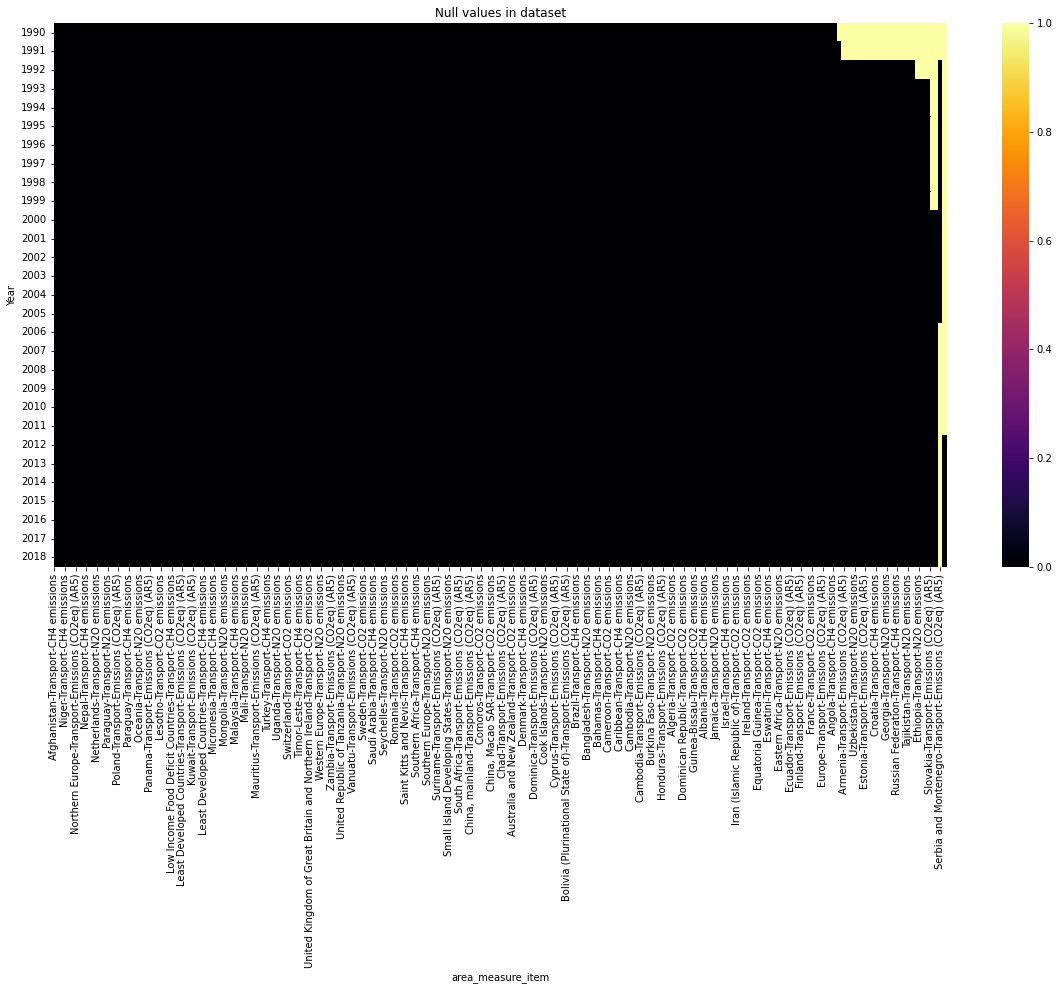

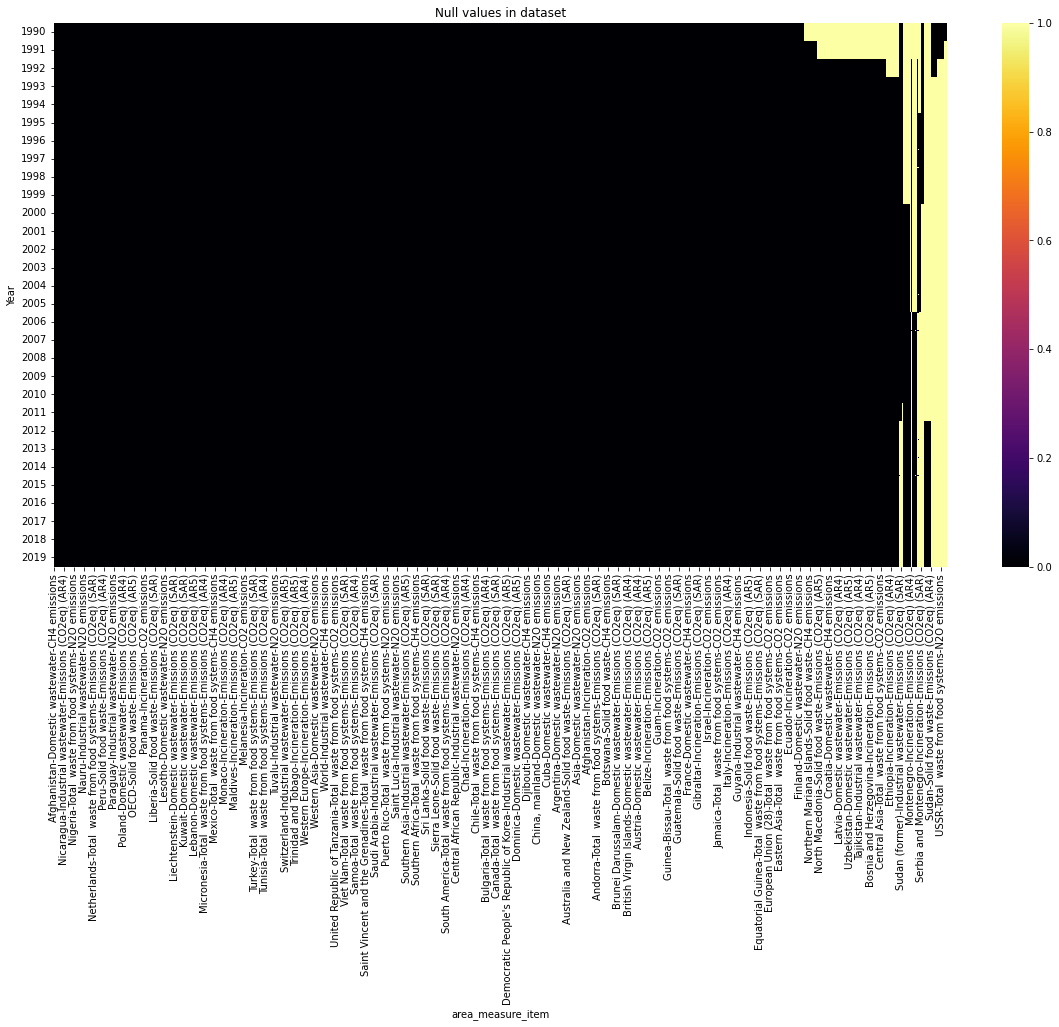

In [18]:

df_food_balances = show_and_fill_na_values(df_food_balances)
  
df_emissions = show_and_fill_na_values(df_emissions)

df_food_transport = show_and_fill_na_values(df_food_transport)

df_waste_disposal = show_and_fill_na_values(df_waste_disposal)

In [ ]:
df = pd.read_csv(Database, encoding = "ISO-8859-1")

# DATA UNDERSTANDING

## Análisis de los datos

### Tamaño del dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17384700 entries, 0 to 17384699
Data columns (total 11 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Area Code     int64  
 1   Area          object 
 2   Item Code     int64  
 3   Item          object 
 4   Element Code  int64  
 5   Element       object 
 6   Year Code     int64  
 7   Year          int64  
 8   Unit          object 
 9   Value         float64
 10  Flag          object 
dtypes: float64(1), int64(5), object(5)
memory usage: 1.4+ GB


### Visualización directa de los datos

In [ ]:
df.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,862,Alfalfa meal and pellets,5910,Export Quantity,2019,2019,tonnes,49.0,*
1,2,Afghanistan,862,Alfalfa meal and pellets,5910,Export Quantity,2020,2020,tonnes,21.0,*
2,2,Afghanistan,862,Alfalfa meal and pellets,5922,Export Value,2019,2019,1000 US$,18.0,*
3,2,Afghanistan,862,Alfalfa meal and pellets,5922,Export Value,2020,2020,1000 US$,8.0,*
4,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,2014,2014,tonnes,167.0,R


Vemos que como en todas las bases, estan organizadas con la columnas de área corresponde a los países y probablemente a agrupaciones, los Items a priori son alimentos de cultivos y ganadería, según se informa en la FAO hay también agrupaciones, y para cada combinación de País-Item-Año tenemos, según se indica en la columna "Element", tanto la cantidad como el valor de producto importado y exportado.

Las variables, aunque están algunas cogidas como Numéricas, sólo hay dos columnas realmente numéricas, que son el año ("Year") y la columna "Value", ya que lo demás numéricas son identifiers (Area Code, Item Code, Element Code, Year Code, y Unit). El valor de cada columna define de qué se trata el valor numérico de la columna "Value".

Miramos la información que hay en la base de datos

**Area**

Contamos el número de Áreas?

In [ ]:
df["Area"].nunique()

276

Según la web de la FAO, las agrupaciones empiezan en el código 5000. Vemos qué agrupaciones hay.

In [ ]:
df[df["Area Code"]>5000]["Area"].unique()

array(['Africa', 'Africa (excluding intra-trade)', 'Eastern Africa',
       'Eastern Africa (excluding intra-trade)', 'Middle Africa',
       'Middle Africa (excluding intra-trade)', 'Northern Africa',
       'Northern Africa (excluding intra-trade)', 'Southern Africa',
       'Southern Africa (excluding intra-trade)', 'Western Africa',
       'Western Africa (excluding intra-trade)', 'Americas',
       'Americas (excluding intra-trade)', 'Northern America',
       'Northern America (excluding intra-trade)', 'Central America',
       'Central America (excluding intra-trade)', 'Caribbean',
       'Caribbean (excluding intra-trade)', 'South America',
       'South America (excluding intra-trade)', 'Asia',
       'Asia (excluding intra-trade)', 'Central Asia',
       'Central Asia (excluding intra-trade)', 'Eastern Asia',
       'Eastern Asia (excluding intra-trade)', 'Southern Asia',
       'Southern Asia (excluding intra-trade)', 'South-eastern Asia',
       'South-Eastern Asia (excludi

Vemos agrupaciones por continentes y otras agrupaciones de países, como los menos desarrolados, países sin litoral, países con deficit de comida, etc.

In [ ]:
## Hay también una agrupación de todo el mundo.

(df["Area"] == "World").sum()

109807

**Columna Element**

In [ ]:
df["Element"].unique()

array(['Export Quantity', 'Export Value', 'Import Quantity',
       'Import Value'], dtype=object)

Importaciones y exportaciones por cantidad de alimentos y por valor.

**Columna Item**

In [ ]:
df["Item"].unique()

array(['Alfalfa meal and pellets', 'Almonds shelled',
       'Almonds, with shell', 'Animals live nes',
       'Animals, live, non-food', 'Anise, badian, fennel, coriander',
       'Apples', 'Apricots', 'Apricots, dry', 'Areca nuts', 'Artichokes',
       'Asparagus', 'Avocados', 'Bacon and ham', 'Bambara beans',
       'Bananas', 'Barley', 'Beans, dry', 'Beans, green', 'Beehives',
       'Beer of barley', 'Beeswax', 'Beet pulp',
       'Beverages, distilled alcoholic', 'Beverages, fermented rice',
       'Beverages, non alcoholic', 'Blueberries', 'Bran, maize',
       'Bran, sorghum', 'Bran, wheat', 'Brazil nuts, shelled', 'Bread',
       'Broad beans, horse beans, dry', 'Buckwheat', 'Buffaloes',
       'Butter, cow milk', 'Buttermilk, curdled, acidified milk',
       'Cabbages and other brassicas', 'Cake, copra', 'Cake, cottonseed',
       'Cake, groundnuts', 'Cake, linseed', 'Cake, rapeseed',
       'Cake, soybeans', 'Cake, sunflower', 'Camels', 'Canary seed',
       'Carrots and tur

Sabemos, segun la web de FAOSTAT que hay códigos que son agrupaciones de alimentos. Y también según la web, los códigos de alimentos y agrupaciones están separados.

Lo comprobamos:

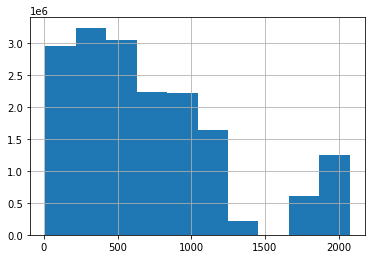

In [ ]:
df["Item Code"].hist()

Además, hay un Item que los agrupa a todos, que és el 10. 

Vemos este Item para el ejemplo de España.


In [ ]:
df[(df["Area"]=="Spain") & (df["Item Code"]==10) & (df["Year"]==df["Year"].max())].head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
10572313,203,Spain,10,Total Merchandise Trade,5622,Import Value,2020,2020,1000 US$,324993909.0,*
10572373,203,Spain,10,Total Merchandise Trade,5922,Export Value,2020,2020,1000 US$,307015020.0,*


Número total de Items, alimentos y agrupaciones.

In [ ]:
df["Item Code"].nunique()

476

In [ ]:
print("Tenemos un total de", df["Item Code"].nunique(), "Items, de los cuales, ", df[df["Item Code"].between(11,1500)==False]["Item Code"].nunique() , "son agrupaciones.")

Tenemos un total de 476 Items, de los cuales,  41 son agrupaciones.


Vemos un ejemplo de las agrupaciones.

In [ ]:
df[df["Item Code"]>1500].Item.unique()

array(['Agricultural Products', 'Cereals and Preparations', 'Cereals',
       'Food Excluding Fish', 'Cereal preparations',
       'Fats and Oils (excluding Butter)',
       'Animal Fats and Oils (excl. Butter)', 'Vegetable Oil and Fat',
       'Meat and Meat Preparations', 'Bovine Meat', 'Poultry Meat',
       'Pigmeat', 'Other Meat', 'Sugar and Honey', 'Fruit and Vegetables',
       'Fruit', 'Vegetables', 'Pulses', 'Roots and Tubers', 'Nuts',
       'Sugar Crops Primary', 'Dairy Products and Eggs', 'Dairy Products',
       'Eggs', 'Beverages', 'Alcoholic Beverages',
       'Non-alcoholic Beverages', 'Other food', 'Live Animals',
       'Oilseeds', 'Other food nes', 'Non-food',
       'Fodder and Feeding Stuff', 'Non-edible Crude Materials',
       'Natural Rubber', 'Textile Fibres', 'Hides and skins',
       'Crude Materials nes', 'Non-edible Fats and Oils', 'Tobacco'],
      dtype=object)

### Resumen
Vemos que la base de datos tiene información por pais y alimento, de la cantidad y valor exportado i importado.
- A parte de los países, hay varias agrupaciones de países como continentes u otras agrupaciones.
- Los alimentos también están agrupados en deiversas categorías, que se solapan entre ellas.
- Se analizarán cuales son los alimentos más exportados/importados y también los países que más alimentos exportan e importan.
- También se mostrará la evolución de las importaciones de alimentos en general, i por países más importadores.


### Miramos si hay nulos o duplicados

In [ ]:
df.isnull().sum()

Area Code             0
Area                  0
Item Code             0
Item                  0
Element Code          0
Element               0
Year Code             0
Year                  0
Unit                  0
Value           2947019
Flag            6924546
dtype: int64

De los 17 millones y pico de registros, tenemos unos casi 3 millones de nulos el la columna "Value", que es donde hay la información de esta base.
Intentamos analizar de qué se tratan estos nulos.

En el "Flag" también hay nulos, pero no es una columna que a priori vayamo a usar.

In [ ]:
df[ df["Value"].isnull()].head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
141,2,Afghanistan,221,"Almonds, with shell",5610,Import Quantity,2017,2017,tonnes,NaN,NaN
148,2,Afghanistan,221,"Almonds, with shell",5622,Import Value,2017,2017,1000 US$,NaN,NaN
275,2,Afghanistan,1171,Animals live nes,5622,Import Value,2017,2017,1000 US$,NaN,NaN
280,2,Afghanistan,1171,Animals live nes,5922,Export Value,2017,2017,1000 US$,NaN,NaN
287,2,Afghanistan,1169,"Animals, live, non-food",5622,Import Value,2017,2017,1000 US$,NaN,NaN


Miramos los nulos por países.

Países con menos nulos

In [ ]:
df.groupby(["Area Code", "Area"])["Value"].apply(lambda x: x.isnull().sum()).sort_values().head(40)

Area Code  Area                                                           
261        European Union (12) (excluding intra-trade)                          0
266        European Union (15) (excluding intra-trade)                          0
268        European Union (25) (excluding intra-trade)                          0
57070      European Union (27) (excluding intra-trade)                          0
269        European Union (27) (excluding Croatia) (excluding intra-trade)      0
54040      Western Europe (excluding intra-trade)                               0
54020      Northern Europe (excluding intra-trade)                              0
57060      European Union (28) (excluding intra-trade)                          6
55040      Polynesia (excluding intra-trade)                                   13
55010      Australia and New Zealand (excluding intra-trade)                   18
54030      Southern Europe (excluding intra-trade)                             26
55000      Oceania (exc

La mayoría com pocos nulos son agrupaciones. Tiene sentido. Se podría analizar la evolución de los nulos en el tiempo. Hay quizás años en los que no hay valores? 


Países con más nulos

In [ ]:
df.groupby(["Area Code", "Area"])["Value"].apply(lambda x: x.isnull().sum()).sort_values().tail(20)

Area Code  Area                       
8          Antigua and Barbuda            27256
173        Poland                         27882
299        Palestine                      28045
153        New Caledonia                  28437
215        United Republic of Tanzania    28667
249        Yemen                          28795
141        Mongolia                       29493
13         Bahrain                        30466
91         Guyana                         30485
115        Cambodia                       30562
75         Gambia                         30968
179        Qatar                          32795
226        Uganda                         33224
184        Rwanda                         33871
225        United Arab Emirates           34431
149        Nepal                          34848
81         Ghana                          36871
209        Eswatini                       39228
3          Albania                        43765
147        Namibia                        52689
N

Analizamos los Nulos por año

In [ ]:
nulos = df.groupby(["Year"])["Value"].apply(lambda x: x.isnull().sum())

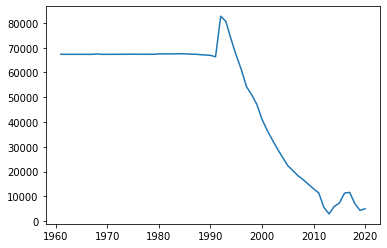

In [ ]:
plt.plot(nulos)

- Los nulos están concentrados en los años más anteriores. 
- Hay un salto extraño cerca de 1992. ¿Puede que se incluyeran nuevos alimentos? 



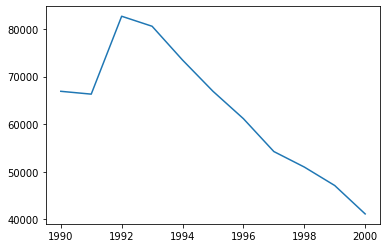

In [ ]:
## Hacemos zoom en los años cercanos al 1992

plt.plot(nulos.loc[1990:2000])

Efectivamente hay un cambio en el 1992

In [ ]:
df[df.Year == 1991]["Item"].nunique()

473

In [ ]:
df[df.Year == 1992]["Item"].nunique()

473

In [ ]:
df[df.Year == 1991]["Area"].nunique()

238

In [ ]:
df[df.Year == 1992]["Area"].nunique()

258

Pero si hay más paises. Quizás los nuevos países tienen muchos nulos.. Se podría seguir analizando...

In [ ]:
df[df.Year == 1991].shape

(288020, 11)

In [ ]:
df[df.Year == 1992].shape

(314377, 11)

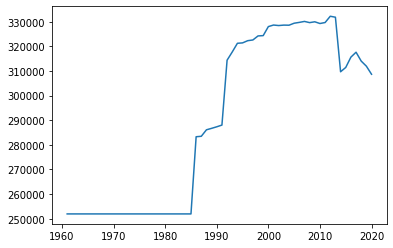

In [ ]:
plt.plot(df.groupby("Year")["Value"].apply(lambda x:len(x)))

Vemos que hay un salto en el número de registros.... así pues, podría ser  que ese salto en los nulos sea debido a que se ha cambiado la forma en la que se guardan los datos.

De todos modos, en los últimos años vemos una reducción importante de los nulos mientras que el total de registros no tiene una reducción progresiva.

Miramos en los últimos años, en qué paises están repartidos los nulos.

In [ ]:
df_ult_año_paises = df[(df.Year == 2020) & (df["Area Code"]<5000)]
df_ult_año_paises.groupby(["Area Code", "Area"])["Value"].apply(lambda x: x.isnull().sum()).sort_values(ascending=False).head(40)

Area Code  Area                
136        Mauritania              247
35         Cabo Verde              240
233        Burkina Faso            225
58         Ecuador                 186
170        Peru                    182
40         Chile                   171
194        Saudi Arabia            167
225        United Arab Emirates    165
46         Congo                   153
53         Benin                   146
196        Seychelles              145
169        Paraguay                142
45         Comoros                 140
158        Niger                   132
143        Morocco                 130
129        Madagascar              121
209        Eswatini                119
48         Costa Rica              115
118        Kuwait                  115
56         Dominican Republic      107
26         Brunei Darussalam       103
144        Mozambique              101
130        Malawi                   98
108        Kazakhstan               97
185        Russian Federation   

Observamos que hay mayor concentración de nulos en países de África y Suramérica. No aparecen países de Europa o Norteamérica. 

In [ ]:
#Observamos los nulos de "Saudi Arabia"

df[(df.Year == 2020) & (df["Area Code"]==194) & (df["Value"].isnull())].head(20)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
9833498,194,Saudi Arabia,1171,Animals live nes,5622,Import Value,2020,2020,1000 US$,NaN,NaN
9834640,194,Saudi Arabia,226,Areca nuts,5910,Export Quantity,2020,2020,tonnes,NaN,NaN
9834642,194,Saudi Arabia,226,Areca nuts,5922,Export Value,2020,2020,1000 US$,NaN,NaN
9835554,194,Saudi Arabia,1039,Bacon and ham,5610,Import Quantity,2020,2020,tonnes,NaN,NaN
9835557,194,Saudi Arabia,1039,Bacon and ham,5622,Import Value,2020,2020,1000 US$,NaN,NaN
9836099,194,Saudi Arabia,44,Barley,5910,Export Quantity,2020,2020,tonnes,NaN,NaN
9836155,194,Saudi Arabia,44,Barley,5922,Export Value,2020,2020,1000 US$,NaN,NaN
9836211,194,Saudi Arabia,46,"Barley, pearled",5610,Import Quantity,2020,2020,tonnes,NaN,NaN
9836267,194,Saudi Arabia,46,"Barley, pearled",5622,Import Value,2020,2020,1000 US$,NaN,NaN
9837138,194,Saudi Arabia,51,Beer of barley,5610,Import Quantity,2020,2020,tonnes,NaN,NaN


In [ ]:
# Quizás los nulos equivalen a 0. Miramos la evolucion temporal de algunos de los alimentos con nulos de Arabia Saudi. 
# Por ejemplo las importaciones (Elemento 5622) de Cider (código 517)

df[(df.Year.between(1990,2020)) & (df["Area Code"]==194) & (df["Item Code"] == 517) & (df["Element Code"]==5622)].tail(20)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
9847587,194,Saudi Arabia,517,Cider etc,5622,Import Value,1997,1997,1000 US$,0.0,F
9847588,194,Saudi Arabia,517,Cider etc,5622,Import Value,1998,1998,1000 US$,0.0,F
9847589,194,Saudi Arabia,517,Cider etc,5622,Import Value,1999,1999,1000 US$,0.0,F
9847590,194,Saudi Arabia,517,Cider etc,5622,Import Value,2000,2000,1000 US$,0.0,NaN
9847591,194,Saudi Arabia,517,Cider etc,5622,Import Value,2001,2001,1000 US$,0.0,NaN
9847592,194,Saudi Arabia,517,Cider etc,5622,Import Value,2002,2002,1000 US$,0.0,F
9847593,194,Saudi Arabia,517,Cider etc,5622,Import Value,2003,2003,1000 US$,31.0,R
9847594,194,Saudi Arabia,517,Cider etc,5622,Import Value,2004,2004,1000 US$,73.0,R
9847595,194,Saudi Arabia,517,Cider etc,5622,Import Value,2005,2005,1000 US$,0.0,*
9847596,194,Saudi Arabia,517,Cider etc,5622,Import Value,2006,2006,1000 US$,0.0,F


En este caso, vemos que en años anteriores habían 0's y luego ha pasado a nulos. Es probable que los nulos representen 0.

Miramos algun otro ejemplo

In [ ]:
#Observamos los nulos de "Mauritania"

df[(df.Year == 2020) & (df["Area Code"]==136) & (df["Value"].isnull())].head(20)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
7192517,136,Mauritania,231,Almonds shelled,5610,Import Quantity,2020,2020,tonnes,NaN,NaN
7192573,136,Mauritania,231,Almonds shelled,5622,Import Value,2020,2020,1000 US$,NaN,NaN
7192848,136,Mauritania,1169,"Animals, live, non-food",5922,Export Value,2020,2020,1000 US$,NaN,NaN
7192904,136,Mauritania,711,"Anise, badian, fennel, coriander",5610,Import Quantity,2020,2020,tonnes,NaN,NaN
7192960,136,Mauritania,711,"Anise, badian, fennel, coriander",5622,Import Value,2020,2020,1000 US$,NaN,NaN
7193136,136,Mauritania,526,Apricots,5610,Import Quantity,2020,2020,tonnes,NaN,NaN
7193192,136,Mauritania,526,Apricots,5622,Import Value,2020,2020,1000 US$,NaN,NaN
7193248,136,Mauritania,527,"Apricots, dry",5610,Import Quantity,2020,2020,tonnes,NaN,NaN
7193251,136,Mauritania,527,"Apricots, dry",5622,Import Value,2020,2020,1000 US$,NaN,NaN
7193641,136,Mauritania,1039,Bacon and ham,5610,Import Quantity,2020,2020,tonnes,NaN,NaN


In [ ]:
# Observamos ahora la evolución de uno de los Items con nulos

df[(df.Year.between(1990,2020)) & (df["Area Code"]==136) & (df["Item Code"] == 711) & (df["Element Code"]==5622)].tail(20)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
7192941,136,Mauritania,711,"Anise, badian, fennel, coriander",5622,Import Value,1997,1997,1000 US$,NaN,M
7192942,136,Mauritania,711,"Anise, badian, fennel, coriander",5622,Import Value,1998,1998,1000 US$,NaN,M
7192943,136,Mauritania,711,"Anise, badian, fennel, coriander",5622,Import Value,1999,1999,1000 US$,NaN,M
7192944,136,Mauritania,711,"Anise, badian, fennel, coriander",5622,Import Value,2000,2000,1000 US$,NaN,M
7192945,136,Mauritania,711,"Anise, badian, fennel, coriander",5622,Import Value,2001,2001,1000 US$,NaN,M
7192946,136,Mauritania,711,"Anise, badian, fennel, coriander",5622,Import Value,2002,2002,1000 US$,NaN,M
7192947,136,Mauritania,711,"Anise, badian, fennel, coriander",5622,Import Value,2003,2003,1000 US$,NaN,M
7192948,136,Mauritania,711,"Anise, badian, fennel, coriander",5622,Import Value,2004,2004,1000 US$,NaN,M
7192949,136,Mauritania,711,"Anise, badian, fennel, coriander",5622,Import Value,2005,2005,1000 US$,NaN,M
7192950,136,Mauritania,711,"Anise, badian, fennel, coriander",5622,Import Value,2006,2006,1000 US$,NaN,M


En este caso también podría ser buena opción poner 0's. 
Parece que en los casos con nulos, se repiten Nulos y 0's en otros años. Quizás una buena estrategia sería rellenar los Nulos con 0's, y más teniendo en cuenta que en caso de tener información del país con el que se hace una transacción, los campos ya se rellenan con esa información.

# EDA

### Vamos a ver cuales han sido los países  más exportadores el último año.
Tenemos en cuenta lo siguiente:
- Las agrupaciones de paises están en los códigos mayores de 5000
- Las agrupaciones de productos están en los códigos mayores de 1500

In [ ]:
ult_año = df["Year"].max()

In [ ]:
# Filtramos la base de datos para quedarnos la cantidad exportada de alimentos (no agrupaciones), por países (no agrupaciones) en el último año.

df_Paises_Export_q_2020 = df[ (df["Element"] == "Export Quantity") & (df["Area Code"] < 5000) & (df["Year"] == ult_año ) & (df["Item Code"] < 1500 )]

In [ ]:
df_Paises_Export_q_2020.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
1,2,Afghanistan,862,Alfalfa meal and pellets,5910,Export Quantity,2020,2020,tonnes,21.0,*
77,2,Afghanistan,231,Almonds shelled,5910,Export Quantity,2020,2020,tonnes,4123.0,R
211,2,Afghanistan,221,"Almonds, with shell",5910,Export Quantity,2020,2020,tonnes,2546.0,*
371,2,Afghanistan,711,"Anise, badian, fennel, coriander",5910,Export Quantity,2020,2020,tonnes,15176.0,R
611,2,Afghanistan,515,Apples,5910,Export Quantity,2020,2020,tonnes,29776.0,R


In [ ]:
# Agrupamos por país y sumamos todas las cantidades exportadas

gb_df_Paises_Export_q_2020 = df_Paises_Export_q_2020.groupby(["Year","Area","Element"])["Value"].sum().reset_index()

In [ ]:
tabla_orden=gb_df_Paises_Export_q_2020.sort_values("Value", ascending=True).tail(20).reset_index(drop=True)

In [ ]:
tabla_orden.head()

,Year,Area,Element,Value
0,2020,Malaysia,Export Quantity,26937042.0
1,2020,Poland,Export Quantity,27748419.0
2,2020,Australia,Export Quantity,31572071.0
3,2020,China (excluding intra-trade),Export Quantity,32719976.0
4,2020,Belgium,Export Quantity,36037663.0


In [ ]:
fig = px.bar(tabla_orden, 
             x="Value", y="Area", title='Cantidad Total Exportada en Toneladas el 2020', text='Value', orientation='h', 
             width=700, height=700, range_x = [0, max(gb_df_Paises_Export_q_2020['Value'])+50000000])
fig.update_traces(marker_color='#46cdcf', opacity=0.8, textposition='outside')

Países más exportadores de alimentos: USA y Brasil con diferencia. China, aunque es probablemente el país más exportador del mundo, no es un gran exportador de alimentos. 

### Vamos a ver ahora los países  más importadores en el último año.
Tenemos en cuenta lo siguiente:
- Las agrupaciones de paises están en los códigos mayores de 5000
- Las agrupaciones de productos están en los códigos mayores de 1500

In [ ]:
df_Paises_Import_q_2020 = df[ (df["Element"] == "Import Quantity") & (df["Area Code"] < 5000) & (df["Year"] == ult_año ) & (df["Item Code"] < 1500 )]

gb_df_Paises_Import_q_2020 = df_Paises_Import_q_2020.groupby(["Year","Area","Element"])["Value"].sum().reset_index()

tabla_orden=gb_df_Paises_Import_q_2020.sort_values("Value", ascending=True).tail(20).reset_index(drop=True)

In [ ]:
fig = px.bar(tabla_orden, 
             x="Value", y="Area", title='Cantidad Total Importada en Toneladas el 2020', text='Value', orientation='h', 
             width=700, height=700, range_x = [0, max(gb_df_Paises_Import_q_2020['Value'])+150000000])
fig.update_traces(marker_color='#46cdcf', opacity=0.8, textposition='outside')

### Evolución de las importaciones y exportaciones por países más exportadores e importadores.

#### Países más exportadores

In [ ]:
# Paises más exportadores
top_paises_exp = gb_df_Paises_Export_q_2020.sort_values("Value").tail(20)["Area"].to_list()


In [ ]:
df_Paises_Export_q = df[ (df["Element"] == "Export Quantity") & (df["Area"].isin(top_paises_exp)) & (df["Item Code"] < 1500 )]

In [ ]:
#GRAFICO EVOLUTIVO HORIZONTAL DE LOS CASOS DEL COVID POR PAIS Y FECHA
grafico_horizontal = df_Paises_Export_q.groupby(['Area', 'Year'])['Value'].sum().reset_index()

evolucion_horizontal = px.bar(grafico_horizontal, x="Year", y="Value", color='Area', orientation='v', height=500,
             title='Toneladas Exportadas por Año', color_discrete_sequence = px.colors.cyclical.mygbm)

evolucion_horizontal.show()

- Estados Unidos es el país más exportador de cultivos y productos de ramadería en los últimos 60 años
- Brasil es el país que más ha aumentado su exportación, con una tendencia a superar EEUU en los próximos años.
- Argentina tambíen ha pasado a ser un gran exportador en los últimos 20 años
- los demás paises se mantienen bastante estables en los últimos años.

In [ ]:
# Grafico evolutivo de lineas, no barras apiladas.

evolutivo_lineas = df_Paises_Export_q.groupby(['Area', 'Year'])['Value'].sum().reset_index().sort_values('Year', ascending=True)
#data.groupby(['Fecha', 'Pais'])['Confirmed'].sum().reset_index().sort_values('Confirmed', ascending=False)

px.line(evolutivo_lineas, x="Year", y="Value", color='Area', title='Evolutivo', height=500)

Aquí podemos observar que aunque no en una gran proporción, todos los países han tenido unta tendencia a la alza en las exportaciones.

Entre los destacados según la tendencia alcista, a parte de Brasil (el que más crece), EEUU y Argentina, encontramos países como Canadá  o Rusia.

Qué exportan Brasil, Estados Unidos y Argentina?

In [ ]:
top3_paises_exp = gb_df_Paises_Export_q_2020.sort_values("Value").tail(3)["Area"].to_list()
top3_paises_exp

['Argentina', 'Brazil', 'United States of America']

In [ ]:
df_USA = df[ (df["Element"] == "Export Quantity") & (df["Area"] == 'United States of America') & (df["Year"] == ult_año ) & (df["Item Code"] < 1500 )].sort_values("Value", ascending=False).head(10)
df_USA

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
12028495,231,United States of America,236,Soybeans,5910,Export Quantity,2020,2020,tonnes,64571021.0,NaN
11998373,231,United States of America,56,Maize,5910,Export Quantity,2020,2020,tonnes,51838933.0,NaN
12038927,231,United States of America,15,Wheat,5910,Export Quantity,2020,2020,tonnes,26131626.0,NaN
11976836,231,United States of America,654,"Dregs from brewing, distillation",5910,Export Quantity,2020,2020,tonnes,10958614.0,NaN
11964254,231,United States of America,238,"Cake, soybeans",5910,Export Quantity,2020,2020,tonnes,10044220.0,NaN
12028015,231,United States of America,83,Sorghum,5910,Export Quantity,2020,2020,tonnes,6586580.0,NaN
11985206,231,United States of America,651,Forage products,5910,Export Quantity,2020,2020,tonnes,4708311.0,NaN
11974210,231,United States of America,767,Cotton lint,5910,Export Quantity,2020,2020,tonnes,3822303.0,NaN
12001705,231,United States of America,1058,"Meat, chicken",5910,Export Quantity,2020,2020,tonnes,3546799.0,NaN
12025149,231,United States of America,30,"Rice, paddy (rice milled equivalent)",5910,Export Quantity,2020,2020,tonnes,2791901.0,A


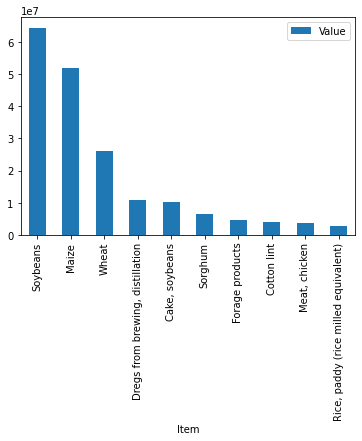

In [ ]:
df_USA.plot(x="Item", y="Value",kind="bar")

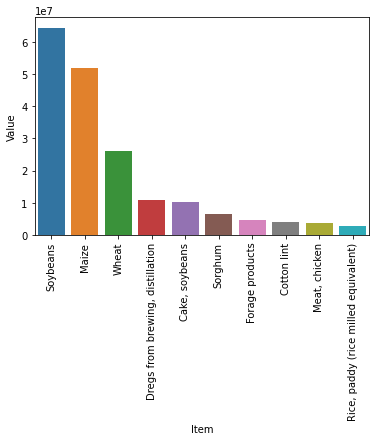

In [ ]:
ax = sns.barplot(data=df_USA, x="Item", y="Value")
b = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)   #  si no lo igualo a alguna variable, me aparece una llista sobre el gráfico.

In [ ]:
df_BRA = df[ (df["Element"] == "Export Quantity") & (df["Area"] == 'Brazil') & (df["Year"] == ult_año ) & (df["Item Code"] < 1500 )].sort_values("Value", ascending=False).head(10)
df_BRA

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
1472409,21,Brazil,236,Soybeans,5910,Export Quantity,2020,2020,tonnes,82973413.0,NaN
1444042,21,Brazil,56,Maize,5910,Export Quantity,2020,2020,tonnes,34431936.0,NaN
1474413,21,Brazil,162,Sugar Raw Centrifugal,5910,Export Quantity,2020,2020,tonnes,26675030.0,NaN
1411975,21,Brazil,238,"Cake, soybeans",5910,Export Quantity,2020,2020,tonnes,16937916.0,NaN
1474653,21,Brazil,164,Sugar refined,5910,Export Quantity,2020,2020,tonnes,3960898.0,Im
1446886,21,Brazil,1058,"Meat, chicken",5910,Export Quantity,2020,2020,tonnes,3899503.0,NaN
1420209,21,Brazil,656,"Coffee, green",5910,Export Quantity,2020,2020,tonnes,2372633.0,Im
1421479,21,Brazil,767,Cotton lint,5910,Export Quantity,2020,2020,tonnes,2125418.0,NaN
1446646,21,Brazil,870,"Meat, cattle, boneless (beef & veal)",5910,Export Quantity,2020,2020,tonnes,1715557.0,NaN
1440600,21,Brazil,491,"Juice, orange, single strength",5910,Export Quantity,2020,2020,tonnes,1323301.0,NaN


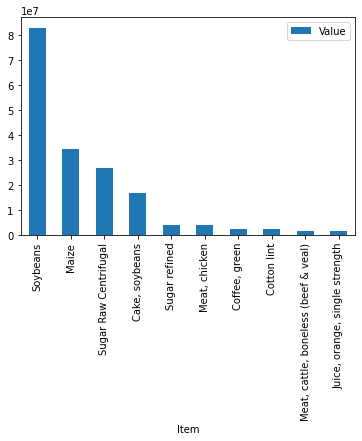

In [ ]:
df_BRA.plot(x="Item", y="Value",kind="bar")

#### Países más importadores

In [ ]:

top_paises_imp = gb_df_Paises_Import_q_2020.sort_values("Value").tail(20)["Area"].to_list()

df_Paises_Import_q = df[ (df["Element"] == "Import Quantity") & (df["Area"].isin(top_paises_imp)) & (df["Item Code"] < 1500 )]

# Grafico evolutivo de lineas, no barras apiladas.

evolutivo_lineas = df_Paises_Import_q.groupby(['Area', 'Year'])['Value'].sum().reset_index().sort_values('Year', ascending=True)
#data.groupby(['Fecha', 'Pais'])['Confirmed'].sum().reset_index().sort_values('Confirmed', ascending=False)

px.line(evolutivo_lineas, x="Year", y="Value", color='Area', title='Evolutivo', height=500)

Vemos China aumentando las importaciones a una velocidad sin precedentes probablemente en consonancia al augmento del poder adquisitivo de la población y aumento de la clase media-alta!! También destaca Myanmar como dato anecdótico.

### Qué importa China?? Evolución.

In [ ]:
[x for x in list(df["Area"].drop_duplicates()) if "China" in x]

['China',
 'China, Hong Kong SAR',
 'China, Macao SAR',
 'China, mainland',
 'China, Taiwan Province of',
 'China (excluding intra-trade)']

In [ ]:
df_CHI = df[ (df["Element"] == "Import Quantity") & (df["Area"] == 'China (excluding intra-trade)') & (df["Year"] == ult_año ) & (df["Item Code"] < 1500 )].sort_values("Value", ascending=False).head(10)


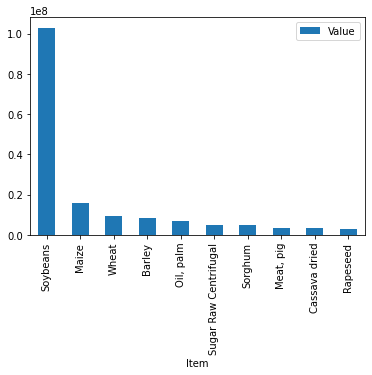

In [ ]:
df_CHI.plot(x="Item", y="Value",kind="bar")

### Producto más exportado a nivel mundial

In [ ]:
gb_df_Item_Export_q_2020 = df_Paises_Export_q_2020.groupby(["Year","Item","Element"])["Value"].sum().reset_index()

In [ ]:
tabla_orden = gb_df_Item_Export_q_2020.sort_values("Value", ascending=True).tail(20)
fig = px.bar(tabla_orden, 
             x="Value", y="Item", title='Cantidad Total Exportada en Toneladas el 2020 por alimento', text='Value', orientation='h', 
             width=700, height=700, range_x = [0, max(tabla_orden['Value'])+100000000])
fig.update_traces(marker_color='#46cdcf', opacity=0.8, textposition='outside')


Los productos más exportados son: Trigo, Maiz y soja.

In [ ]:
gb_df_Item_Export_q_2020.sort_values("Value", ascending=False).head(5)

,Year,Item,Element,Value
380,2020,Wheat,Export Quantity,198526653.0
200,2020,Maize,Export Quantity,192896519.0
335,2020,Soybeans,Export Quantity,173523856.0
49,2020,"Cake, soybeans",Export Quantity,68264630.0
294,2020,Pigs,Export Quantity,48704535.0


### Producto más importado a nivel mundial

In [ ]:
gb_df_Item_Import_q_2020 = df_Paises_Import_q_2020.groupby(["Year","Item","Element"])["Value"].sum().reset_index()

In [ ]:
gb_df_Item_Import_q_2020.sort_values("Value", ascending=False).head(20)

,Year,Item,Element,Value
336,2020,Soybeans,Import Quantity,372929173.0
379,2020,"Waters,ice etc",Import Quantity,217540334.0
201,2020,Maize,Import Quantity,216715155.0
381,2020,Wheat,Import Quantity,211923818.0
320,2020,"Rodents, other",Import Quantity,70154904.0
50,2020,"Cake, soybeans",Import Quantity,67379574.0
268,2020,"Oil, palm",Import Quantity,60927212.0
342,2020,Sugar Raw Centrifugal,Import Quantity,49552257.0
15,2020,Barley,Import Quantity,49103094.0
319,2020,"Rice, paddy (rice milled equivalent)",Import Quantity,48622805.0


No acabo de entender porque el Item "Waters, Ice etc" aparece en la tabla de productos más importados pero no en la de más exportados....

### Podríamos seguir analizando, y ver la evolución de las exportaciones e importaciones por alimentos.